***

# <center>__Utilizing Machine Learning__</center>
# <center>__for High Frequency Algorithmic Trading__</center>


##### <center>__Name:__ Masixole Boya</center>
##### <center>__Student number:__ 1869204</center>

***
### __Key Objectives__ 
- Get a site that can supply the data
  - Retrieve the data from this site, import into my file
  - Get used to the format the data is retrieved in (*.i.e.* in JSON, in this case)
- Get the model training on this data
  - Train the model in the format of retreival or format it into a format suitable for training

# __Table of Contents__

- [0. Imports](#0-imports)
- [1. Requesting the data](#1-requesting-the-data)
  - [1.1 API Parameters](#11-api-parameters)
- [2. Analysis & Processing](#2-analysis--processing)
  - [2.1 Basic Analysis](#21-basic-analysis)
  - [2.2 Preprocessing](#22-preprocessing)
    - [2.2.1 Scaling](#221-scaling)
    - [2.2.2 Creating training data](#222-creating-training-data)
    - [2.2.3 Splitting: Training, Validation, Testing Data](#223-splitting-training-validation-testing-data)
- [3. Training the model](#224-training-the-model)
- [4. Model Evaluation](#3-model-evaluation)


# __0. Imports__

In [1]:
from secret_key import Secret
import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import pytz

<h1>
    <b>1. Requesting the data </b> : Tiingo API
</h1>
<h4><i> Here I explain the 'parameters' that the <b>api url</b> requires</i></h4>
<h4>The `tiingo` API gives `intraday data` which seems to <b><i>delay by 10 mins</i></b> from real time, and top-of-book data. Here, I shall train with the intraday data, but I will still request the top-of-book to analyse how different it is. The smallest time unit for this API  is <b>1 minute<b/></h4>

<h2>
    <b>1.1 API Parameters</b>
</h2>
<ul>
    <li>
        <strong> Ticker</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li><u>DATA TYPE:</u>  string
            </li>
            <li><u>REQUIRED:</u>
            </li>
        </ul>
    </li>
    <li> 
        <strong>Start Date</strong>
        <ul>
            <li><u>JSON FIELD:</u>
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong>End Date</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: date (YYYY-MM-DD)
            </li>
            <li>REQUIRED:
            </li>
        </ul>
    </li>
    <li>
        <strong> Resample Freq</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string (e.g. "15min" or "4hour". )
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: 5min
            </li>
        </ul>
    </li>
    <li>
        <strong>Response Format</strong>
        <ul>
            <li>JSON FIELD:
            </li>
            <li>DATA TYPE: string
            </li>
            <li>REQUIRED:
            </li>
            <li>DEFAULT: JSON
            </li>
        </ul>
    </li>
</ul>


In [2]:
headers =  {
    'Content-Type' : 'application/json'
}

In [55]:
ticker = 'EURUSD'
start_date = '2024-01-01'
end_date = '2024-04-07'
resample_freq = '1min'


<h2>
    <b>1.2 Requesting Intraday Data</b>
</h2>

In [56]:
# requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/{ticker.lower()}/prices?startDate={start_date}&resampleFreq={resample_freq}&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)

requestResponse = requests.get(f"https://api.tiingo.com/tiingo/fx/
                               {ticker.lower()}/prices?
                               startDate={start_date}&
                               endDate={end_date}&
                               resampleFreq={resample_freq}&
                               token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", 
                               headers=headers)


In [57]:
data = requestResponse.json() 
data[1] 

{'date': '2024-01-01T21:01:00.000Z',
 'ticker': 'eurusd',
 'open': 1.104595,
 'high': 1.104595,
 'low': 1.104595,
 'close': 1.104595}

In [58]:

print(f"Last data item: {data[-1]['date']}")

utc_time_str = '2024-03-18T21:10:00.000Z'
sa_time = datetime.strptime(utc_time_str, '%Y-%m-%dT%H:%M:%S.%fZ').replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Africa/Johannesburg'))

#South African time
print("\nSouth African Time:", sa_time.strftime('%Y-%m-%d %H:%M:%S'))



Last data item: 2024-01-07T22:40:00.000Z

South African Time: 2024-03-18 23:10:00



<h2>
    <b>1.3 Requesting Top-Of-Book Data</b>
</h2>

#### This shows the latest price - at the exact time of running this cell

In [59]:
requestResponseTOB = requests.get(f"https://api.tiingo.com/tiingo/fx/top?tickers={ticker.lower()}&token=ebed6535a2acbe1a06b0057e8d1e8af61e5cefa7", headers=headers)
tob_data = requestResponseTOB.json()
tob_data

[{'ticker': 'eurusd',
  'quoteTimestamp': '2024-04-07T21:13:39.649000+00:00',
  'bidPrice': 1.08349,
  'bidSize': 1000000.0,
  'askPrice': 1.0841,
  'askSize': 1000000.0,
  'midPrice': 1.083795}]

# __2. Analysis & Processing__

<h2><strong>2.1 Basic Analysis</strong></h2>

In [60]:
df= pd.DataFrame(data)
df.shape

(5757, 6)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5757 entries, 0 to 5756
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5757 non-null   object 
 1   ticker  5757 non-null   object 
 2   open    5757 non-null   float64
 3   high    5757 non-null   float64
 4   low     5757 non-null   float64
 5   close   5757 non-null   float64
dtypes: float64(4), object(2)
memory usage: 270.0+ KB


#### I use the `df.tail()` method to be able to see the __latest__ time the data ends at.

In [50]:
df.tail()

,date,ticker,open,high,low,close
7127,2023-02-03T21:35:00.000Z,eurusd,1.079580,1.079715,1.079455,1.079625
7128,2023-02-03T21:40:00.000Z,eurusd,1.079615,1.079640,1.079445,1.079455
7129,2023-02-03T21:45:00.000Z,eurusd,1.079465,1.079525,1.079280,1.079310
7130,2023-02-03T21:50:00.000Z,eurusd,1.079315,1.079385,1.079275,1.079345
7131,2023-02-03T21:55:00.000Z,eurusd,1.079325,1.079475,1.079305,1.079410


In [51]:
type(df['date'])


pandas.core.series.Series

In [52]:
df['date'] = pd.to_datetime(df['date'])


In [53]:
df.set_index('date', inplace=True)


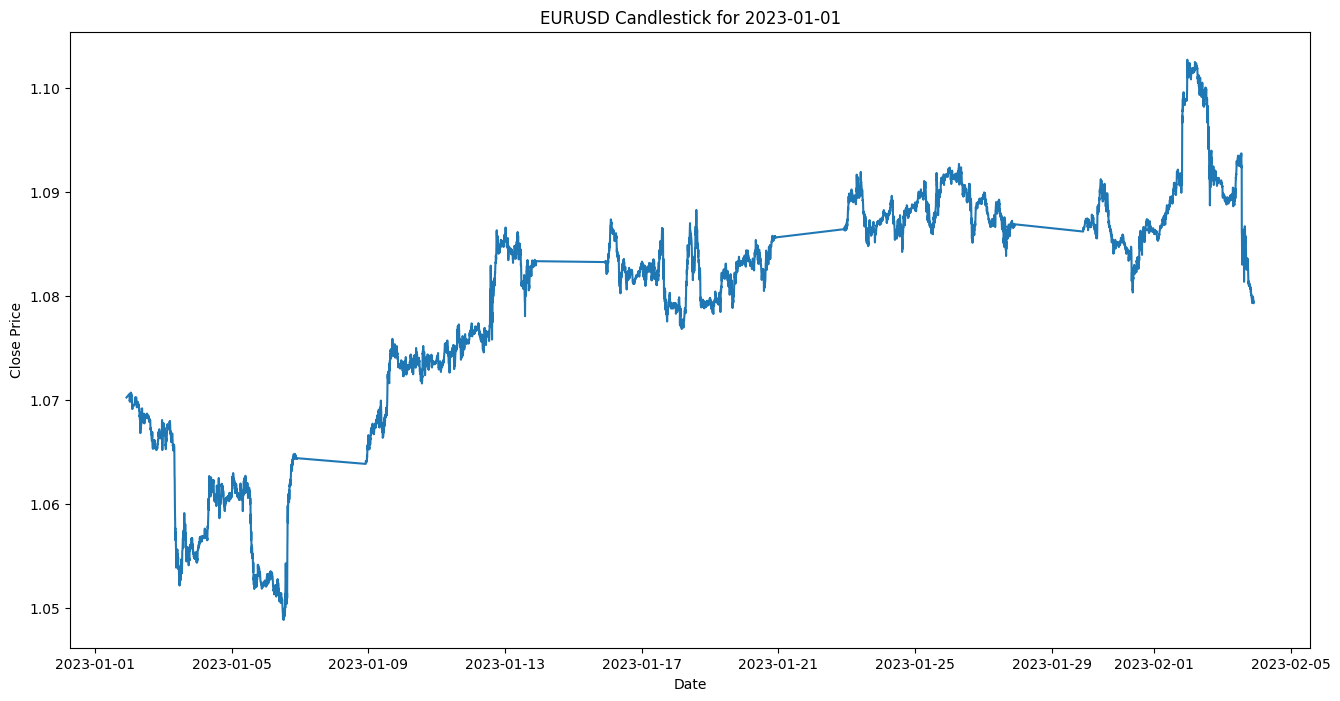

In [54]:
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Candlestick for {start_date}')
plt.plot(df['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

<h2><strong>2.2 Preprocessing</strong></h2>

<h3><strong>2.2.1 Scaling<strong></h3>

In [27]:
scaler = StandardScaler()
numerical_features = ['open', 'high', 'low', 'close']  # Assuming these are your numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [28]:

df.head()

,ticker,open,high,low,close
date,,,,,
2024-01-01 21:00:00+00:00,eurusd,2.713959,2.685597,2.741756,2.713525
2024-01-01 21:15:00+00:00,eurusd,2.708366,2.679999,2.738030,2.709795
2024-01-01 21:30:00+00:00,eurusd,2.708366,2.679999,2.738030,2.709795
2024-01-01 21:45:00+00:00,eurusd,2.702774,2.674402,2.731509,2.703269
2024-01-01 21:55:00+00:00,eurusd,2.699977,2.671603,2.729646,2.701404


<h3><strong>2.2.2 Creating training data<strong></h3>

<h4><strong>Preparing Lagged Data</strong></h4>

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [34]:
go_back_by = 10

def create_lagged_dataframe(df, lag_steps=go_back_by):
    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']

    #Creating lagged columns for previous values
    for i in range(1, lag_steps + 1):
        lagged_df[f'PrevValue_{i}'] = df['close'].shift(i)

    return lagged_df.dropna()

lagged_df = create_lagged_dataframe(df)
lagged_df.head()


,DateTime,ActualValue,PrevValue_1,PrevValue_2,PrevValue_3,PrevValue_4,PrevValue_5,PrevValue_6,PrevValue_7,PrevValue_8,PrevValue_9,PrevValue_10
date,,,,,,,,,,,,
2024-01-01 22:35:00+00:00,2024-01-01 22:35:00+00:00,2.678094,2.696742,2.693012,2.696742,2.710728,2.713525,2.701404,2.703269,2.709795,2.709795,2.713525
2024-01-01 22:40:00+00:00,2024-01-01 22:40:00+00:00,2.674364,2.678094,2.696742,2.693012,2.696742,2.710728,2.713525,2.701404,2.703269,2.709795,2.709795
2024-01-01 22:45:00+00:00,2024-01-01 22:45:00+00:00,2.683688,2.674364,2.678094,2.696742,2.693012,2.696742,2.710728,2.713525,2.701404,2.703269,2.709795
2024-01-01 22:50:00+00:00,2024-01-01 22:50:00+00:00,2.693012,2.683688,2.674364,2.678094,2.696742,2.693012,2.696742,2.710728,2.713525,2.701404,2.703269
2024-01-01 22:55:00+00:00,2024-01-01 22:55:00+00:00,2.693945,2.693012,2.683688,2.674364,2.678094,2.696742,2.693012,2.696742,2.710728,2.713525,2.701404


<h4><strong>Prepare LSTM Data</strong></h4>

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [35]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values


dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (6878,)
X shape: (6878, 10)
y shape: (6878,)


<h3><strong>2.2.3 <u>Spliting:</u> Training, Validation, Testing Data<strong></h3>

<h4><strong>Split Data</strong></h4>

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [36]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [37]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 4126 instances ( 59.98836871183484 %)
Validation set: 1376 instances ( 20.005815644082585 %)
Testing set: 1376 instances ( 20.005815644082585 %)



# __3. Training the model__

In [38]:
model = Sequential([layers.Input((go_back_by,1)), # 3 because we are doing 3 past time units
                    layers.LSTM(60),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(32, activation= 'relu'),
                    layers.Dense(1)]) 

model.compile(loss = 'mse', 
              optimizer =  Adam(learning_rate=0.001),
              metrics = ['mean_absolute_error']
              )

In [39]:
history = model.fit(x_train,y_train, epochs = 100, verbose=1)

Epoch 1/100


129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2688 - mean_absolute_error: 0.3428
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - mean_absolute_error: 0.0781
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - mean_absolute_error: 0.0718
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0694
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0670
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0084 - mean_absolute_error: 0.0645
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - mean_absolute_error: 0.0666
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074 - mean_absolute_error: 0.0600
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0566
Epoch 10/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0073 - mean_absolute_error: 0.0609
Epoch 11/100
129/129 ━━━━━━━━━━

<h1><strong>4. Model Evaluation</strong></h1>

In [40]:
history


In [41]:
from sklearn.metrics import r2_score

loss, mae = model.evaluate(x_test, y_test, verbose=0)

#Evaluating on the test data
predictions = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print('Test Loss:', loss)
print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

# # Actual vs. predicted
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.title('Actual vs. Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# loss curve
# history = model.history.history
# plt.figure(figsize=(10, 6))
# plt.plot(history['loss'], label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Loss: 0.0037004302721470594
Mean Absolute Error: 0.03932774439454079
Root Mean Squared Error: 0.060831163
R-squared: 0.9963422644128188
